# Tugas 3.2 : Uji Coba Model Logistic Regression

Pada Tugas 3.2 ini diminta untuk melakukan uji coba model yang telah dibuat dengan algoritma Logistic Regression.

Dibuat Oleh:

*   Nama : Sabil Ahmad Hidayat
*   NIM : 220411100058
*   Kelas : PPW A

Link Code : https://colab.research.google.com/drive/1UBJt_jNWAnwp-Jhg_McgcuYY6zahVKLW?usp=sharing

Link Github : https://github.com/meinhere/ppw/tree/master/publish/tugas-3

## Import Library

In [1]:
!pip install -q Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.3 MB/s eta 0:00:00


In [2]:
# library awal untuk perhitungan dan pengolahan teks
import numpy as np
import re
import pandas as pd

# alat untuk crawling
from urllib.request import urlopen
from bs4 import BeautifulSoup

# monitoring
from tqdm import tqdm

# library untuk praproses teks
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# library untuk proses modeling
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# library untuk evaluasi model
from sklearn.metrics import classification_report, confusion_matrix

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# save model
import pickle
import requests

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**preprocessing** disini digunakan untuk melakukan proses encoding pada label

**train_test_split** digunakan untuk membagi dataset menjadi data training dan testing

**LogisticRegression** digunakan untuk tahap modeling menggunakan library LogisticRegression

**classification_report** dan **confusion_matrix** digunakan untuk melihat laporan dan hasil evaluasi setelah proses training data

**matplotlib** dan **seaborn** digunakan untuk plotting grafik

**pickle** digunakan untuk menyimpan model hasil training dan testing

## Persiapan Data

### Load Data Model

In [3]:
main_df = pd.read_csv('https://raw.githubusercontent.com/meinhere/ppw/master/publish/tugas-2/dataset/data_berita.csv', delimiter=',')
main_df

,No,Judul Berita,Isi Berita,Tanggal Berita,Kategori Berita
0,1,Simak Jadwal dan Lokasi SIM Keliling di Jakart...,"JAKARTA, KOMPAS.com - Surat Izin Mengemudi (S...",07/09/2024,OTOMOTIF
1,2,[POPULER OTOMOTIF] Diskon Motor Honda Septembe...,"JAKARTA, KOMPAS.com - Banyak pembaca yang ingi...",07/09/2024,OTOMOTIF
2,3,"Cek Saldo Minimal BRI, BNI, BCA, Mandiri, dan BSI","JAKARTA, KOMPAS.com - Penting bagi calon nasab...",06/09/2024,MONEY
3,4,"KAI Uji Coba Teknologi ""Face Recognition Board...",KOMPAS.com - PT Kereta Api Indonesia (KAI) Div...,06/09/2024,MONEY
4,5,OJK Blokir 10.890 Entitas Keuangan Ilegal Seja...,"JAKARTA, KOMPAS.com - Otoritas Jasa Keuangan (...",06/09/2024,MONEY
...,...,...,...,...,...
95,96,Waspada Masalah yang Timbul akibat Telat Ganti...,"JAKARTA, KOMPAS.com - Oli mesin pada mobil den...",06/09/2024,OTOMOTIF
96,97,"Sosok Faisal Basri di Mata Para Tokoh, Ekonom ...","JAKARTA, KOMPAS.com - Ekonom senior Faisal Bas...",06/09/2024,MONEY
97,98,"Pendaftaran CPNS Diperpanjang 4 Hari, Pelamar ...","JAKARTA, KOMPAS.com - Pemerintah telah memperp...",06/09/2024,MONEY
98,99,"Harga Emas Terbaru Pegadaian, Jumat 6 Septembe...","JAKARTA, KOMPAS.com - Pegadaian menyediakan be...",06/09/2024,MONEY


### Membuat Fungsi untuk Persiapan Crawling

In [4]:
# fungsi untuk mengambil link yang akan dilakukan crawling
def extract_urls(url):
    html = urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')

    urls = soup.find_all("a", {"class": "paging__link"})
    urls = [url.get('href') for url in urls]

    return urls

# fungsi untuk mengambil isi dari berita
def get_content(url):
    html = urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')

    div = soup.find("div", {"class": "read__content"})
    paragraf = div.find_all("p")

    content = ''
    for p in paragraf:
        content += p.text

    return content


# fungsi utama crawling
def crawl(link = "https://indeks.kompas.com", max_money = 1, max_otomotif = 1, allow_category = ["OTOMOTIF", "MONEY"], is_train = True, title_old = []):
    # inisialisasi variabel penampung hasil berita
    news_data = []

    # inisialisasi persiapan untuk crawling berita
    last_url = extract_urls(link).pop()
    page = last_url.split('=').pop() # jumlah halaman secara otomatis
    # page = 1 # jumlah halaman secara manual

    # persiapan link yang akan dilakukan crawling
    urls = [link + '/?page=' + str(a) for a in range(1, int(page) + 1)]
    count_money = 0
    count_otomotif = 0

    # menelusuri semua link yang telah ditentukan
    for idx, url in enumerate(urls):
        if (len(news_data) == max_money + max_otomotif) :
          break

        html = urlopen(url).read()
        soup = BeautifulSoup(html, 'html.parser')

        # mengambil data yang diperlukan pada struktur html
        links       = soup.find_all("a", {"class": "article-link"})
        titles      = soup.find_all("h2", {"class": "articleTitle"})
        dates       = soup.find_all("div", {"class": "articlePost-date"})
        categories  = soup.find_all("div", {"class": "articlePost-subtitle"})

        news_per_page = len(links) # berita artikel yang ditampilkan

        # memasukkan data ke dalam list
        for elem in tqdm(range(news_per_page), desc=f"Crawling page {idx+1}"):
          news = {}
          category = categories[elem].text
          title = titles[elem].text

          if (category in allow_category):
            if (is_train):
              cond = (category == "MONEY" and count_money < max_money) or (category == "OTOMOTIF" and count_otomotif < max_otomotif)
            else:
              cond = (category == "MONEY" and count_money < max_money) or (category == "OTOMOTIF" and count_otomotif < max_otomotif) and title not in title_old


            if (cond):
              news['No'] = len(news_data) + 1
              news['Judul Berita']     = title
              news['Isi Berita']       = get_content(links[elem].get("href"))
              news['Tanggal Berita']   = dates[elem].text
              news['Kategori Berita']  = category
              news_data.append(news)

              if (category == "MONEY"):
                count_money += 1
              else:
                count_otomotif += 1

        print(f"=======> Money: {count_money} | Otomotif: {count_otomotif} | Total: {count_money + count_otomotif}")

    return news_data

function **extract_urls** digunakan untuk melakukan ekstraksi link url yang memiliki pagination pada halaman awal, sehingga didapat beberapa url yang bisa mengarah ke halaman selanjutnya atau sebelumnya.

function **get_content** digunakan untuk melakukan proses pembuatan isi berita sesuai link berita yang dicari.

### Pengambilan Data Baru

In [5]:
title_old = main_df["Judul Berita"].tolist()

test_news = crawl(max_money=5, max_otomotif=5, is_train=False, title_old=title_old)

Crawling page 1: 100%|██████████| 15/15 [00:01<00:00, 12.46it/s]


=======> Money: 1 | Otomotif: 1 | Total: 2


Crawling page 2: 100%|██████████| 15/15 [00:00<00:00, 22.94it/s]


=======> Money: 2 | Otomotif: 2 | Total: 4


Crawling page 3: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s]


=======> Money: 4 | Otomotif: 3 | Total: 7


Crawling page 4: 100%|██████████| 15/15 [00:00<00:00, 15.58it/s]


=======> Money: 5 | Otomotif: 4 | Total: 9


Crawling page 5: 100%|██████████| 15/15 [00:02<00:00,  5.14it/s]

=======> Money: 5 | Otomotif: 5 | Total: 10


In [6]:
main_df = pd.DataFrame(test_news)
main_df

,No,Judul Berita,Isi Berita,Tanggal Berita,Kategori Berita
0,1,Apa Kabar Toyota Veloz Hybrid?,"JAKARTA, KOMPAS.com - PT Toyota Astra Motor (T...",17/10/2024,OTOMOTIF
1,2,Ekonom Ingatkan Kabinet 'Gemuk' Prabowo Bisa B...,"JAKARTA, KOMPAS.com - Kepala Pusat Makroekonom...",17/10/2024,MONEY
2,3,"IMOS 2024 Siap Digelar, Ini Bocoran Motor yang...","JAKARTA, KOMPAS.com - Pameran otomotif Indones...",17/10/2024,OTOMOTIF
3,4,Mentan Amran Berhentikan Tiga ASN Kementan Kar...,"JAKARTA, KOMPAS.com - Menteri Pertanian (Menta...",17/10/2024,MONEY
4,5,Fintech Lending Batumbu Rombak Jajaran Direksi...,"JAKARTA, KOMPAS.com - Perusahaan fintech peer ...",17/10/2024,MONEY
5,6,Motor Listrik Royal Enfield Meluncur Bulan Dep...,"JAKARTA, KOMPAS.com - Lewat Instagram resmi Ro...",17/10/2024,OTOMOTIF
6,7,"Prabowo Ulang Tahun, Sri Mulyani dan Airlangga...","JAKARTA, KOMPAS.com - Menteri Koordinator Bid...",17/10/2024,MONEY
7,8,Boy Thohir Ungkap Pengusaha Batu Bara Ingin Ba...,"JAKARTA, KOMPAS.com - Presiden Direktur PT Ada...",17/10/2024,MONEY
8,9,"Simak, Perhatikan Cara Melakukan Inreyen Motor...","JAKARTA, KOMPAS.com – Inreyen motor adalah pro...",17/10/2024,OTOMOTIF
9,10,Kebiasaan Pengendara Bikin Peredam Kejut Motor...,"BOGOR, KOMPAS.com - Peredam kejut alias shockb...",17/10/2024,OTOMOTIF


## Praproses Teks

### Membuat Fungsi

In [7]:
# Case Folding
def clean_lower(lwr):
    lwr = lwr.lower() # lowercase text
    return lwr

# Menghapus tanda baca, angka, dan simbol
def clean_punct(text):
    clean_spcl = re.compile('[/(){}\[\]\|@,;_]')
    clean_symbol = re.compile('[^0-9a-z]')
    clean_number = re.compile('[0-9]')
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub(' ', text)
    text = clean_number.sub('', text)
    return text

# Menghaps double atau lebih whitespace
def _normalize_whitespace(text):
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

# Menghapus stopwords
def clean_stopwords(text):
    stopword = set(stopwords.words('indonesian'))
    text = ' '.join(word for word in text.split() if word not in stopword) # hapus stopword dari kolom deskripsi
    return text

# Stemming with Sastrawi
def sastrawistemmer(text):
    factory = StemmerFactory()
    st = factory.create_stemmer()
    text = ' '.join(st.stem(word) for word in tqdm(text.split()) if word in text)
    return text

function **clean_lower** digunakan untuk merubah semua kata atau huruf menjadi huruf kecil semua

function **clean_punct** digunakan untuk menghapus karakter, simbol, dan angka

function **_normalize_whitespace** digunakan untuk menghapus spasi yang double atau lebih dari 2 spasi

function **clean_stopwords** digunakan untuk menghilangkan kata yang tidak perlu (kata hubung, kata tambahan dll)

function **sastrawistemmer** digunakan untuk proses stemming (mendapatkan kata dasar dari suatu kata)

### Clean Lower

In [8]:
# Buat kolom tambahan untuk data description yang telah dilakukan proses case folding
main_df['lwr'] = main_df['Isi Berita'].apply(clean_lower)
casefolding=pd.DataFrame(main_df['lwr'])
casefolding

,lwr
0,"jakarta, kompas.com - pt toyota astra motor (t..."
1,"jakarta, kompas.com - kepala pusat makroekonom..."
2,"jakarta, kompas.com - pameran otomotif indones..."
3,"jakarta, kompas.com - menteri pertanian (menta..."
4,"jakarta, kompas.com - perusahaan fintech peer ..."
5,"jakarta, kompas.com - lewat instagram resmi ro..."
6,"jakarta, kompas.com - menteri koordinator bid..."
7,"jakarta, kompas.com - presiden direktur pt ada..."
8,"jakarta, kompas.com – inreyen motor adalah pro..."
9,"bogor, kompas.com - peredam kejut alias shockb..."


### Clean Punct

In [9]:
# Buat kolom tambahan untuk data description yang telah dilakukan proses penghapusan tanda baca
main_df['clean_punct'] = main_df['lwr'].apply(clean_punct)
main_df['clean_punct']

,clean_punct
0,jakarta kompas com pt toyota astra motor tam...
1,jakarta kompas com kepala pusat makroekonomi...
2,jakarta kompas com pameran otomotif indonesi...
3,jakarta kompas com menteri pertanian mentan ...
4,jakarta kompas com perusahaan fintech peer t...
5,jakarta kompas com lewat instagram resmi roy...
6,jakarta kompas com menteri koordinator bida...
7,jakarta kompas com presiden direktur pt adar...
8,jakarta kompas com inreyen motor adalah pros...
9,bogor kompas com peredam kejut alias shockbr...


### Normalize Whitespace

In [10]:
main_df['clean_double_ws'] = main_df['clean_punct'].apply(_normalize_whitespace)
main_df['clean_double_ws']

,clean_double_ws
0,jakarta kompas com pt toyota astra motor tam m...
1,jakarta kompas com kepala pusat makroekonomi d...
2,jakarta kompas com pameran otomotif indonesia ...
3,jakarta kompas com menteri pertanian mentan am...
4,jakarta kompas com perusahaan fintech peer to ...
5,jakarta kompas com lewat instagram resmi royal...
6,jakarta kompas com menteri koordinator bidang ...
7,jakarta kompas com presiden direktur pt adaro ...
8,jakarta kompas com inreyen motor adalah proses...
9,bogor kompas com peredam kejut alias shockbrea...


### Clean Stopwords

In [11]:
# Buat kolom tambahan untuk data description yang telah dilakukan proses penghapusan stopwords
main_df['clean_sw'] = main_df['clean_double_ws'].apply(clean_stopwords)
main_df['clean_sw']

,clean_sw
0,jakarta kompas com pt toyota astra motor tam m...
1,jakarta kompas com kepala pusat makroekonomi k...
2,jakarta kompas com pameran otomotif indonesia ...
3,jakarta kompas com menteri pertanian mentan am...
4,jakarta kompas com perusahaan fintech peer to ...
5,jakarta kompas com instagram resmi royal enfie...
6,jakarta kompas com menteri koordinator bidang ...
7,jakarta kompas com presiden direktur pt adaro ...
8,jakarta kompas com inreyen motor proses pembel...
9,bogor kompas com peredam kejut alias shockbrea...


### Stemming dengan Sastrawi

In [12]:
# Buat kolom tambahan untuk data description yang telah dilemmatization
main_df['desc_clean_stem'] = main_df['clean_sw'].apply(sastrawistemmer)
main_df['desc_clean_stem']

100%|██████████| 138/138 [00:02<00:00, 48.78it/s]


,desc_clean_stem
0,jakarta kompas com pt toyota astra motor tam m...
1,jakarta kompas com kepala pusat makroekonomi u...
2,jakarta kompas com pamer otomotif indonesia mo...
3,jakarta kompas com menteri tani tan amran sula...
4,jakarta kompas com usaha fintech peer to peer ...
5,jakarta kompas com instagram resmi royal enfie...
6,jakarta kompas com menteri koordinator bidang ...
7,jakarta kompas com presiden direktur pt adaro ...
8,jakarta kompas com inreyen motor proses beli s...
9,bogor kompas com redam kejut alias shockbreake...


## Pembuatan VSM

In [13]:
# Load the saved model from file
github_raw_url = "https://raw.githubusercontent.com/meinhere/ppw/master/publish/tugas-3/model/tfidf_vectorizer.sav"

response = requests.get(github_raw_url)
response.raise_for_status()

vectorizer = pickle.loads(response.content)
vectorizer

TfidfVectorizer()

In [15]:
corpus = main_df['desc_clean_stem']
tfidf = vectorizer.transform(corpus)

tfidf.shape

(10, 3106)

In [17]:
vocabulary = vectorizer.get_feature_names_out().tolist()

tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vocabulary)
tfidf_df['label'] = main_df['Kategori Berita'].tolist()
tfidf_df

,aaion,aali,abadi,abai,abenkh,abnormal,absurd,ac,acara,access,...,yzr,za,zad,zaman,zarco,zenix,zero,zigzag,zona,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,OTOMOTIF
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,MONEY
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034029,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145886,OTOMOTIF
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,MONEY
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,MONEY
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,OTOMOTIF
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037542,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,MONEY
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,MONEY
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,OTOMOTIF
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,OTOMOTIF


## Preparing Data Test

### Encode Label
Dilakukan tahap encoding pada kolom **[Kategori Berita]** dimana data yang yang terdapat didalamnya masih berupa data kategorik (kata) sehingga perlu dirubah menjadi angka agar bisa dimasukkan ke dalam proses training model

In [18]:
# menggunakan label_encoder untuk merubah kata menjadi angka
label_encoder = preprocessing.LabelEncoder()
tfidf_df['label'] = label_encoder.fit_transform(tfidf_df['label'])

tfidf_df

,aaion,aali,abadi,abai,abenkh,abnormal,absurd,ac,acara,access,...,yzr,za,zad,zaman,zarco,zenix,zero,zigzag,zona,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034029,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145886,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037542,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1


## Testing Data

In [19]:
# Load the saved model from file
github_raw_url = "https://raw.githubusercontent.com/meinhere/ppw/master/publish/tugas-3/model/lr_model.sav"

response = requests.get(github_raw_url)
response.raise_for_status()

lr_model = pickle.loads(response.content)
lr_model

LogisticRegression()

In [21]:
y_test = tfidf_df['label']
x_test = tfidf_df.drop(['label'], axis=1)
y_pred = lr_model.predict(x_test)

print(y_pred)

[1 0 1 0 0 1 0 0 1 1]


In [22]:
# melihat nilai actual dan predicted
a = pd.DataFrame({'Actual value': y_test, 'Predicted value':y_pred})
a

,Actual value,Predicted value
0,1,1
1,0,0
2,1,1
3,0,0
4,0,0
5,1,1
6,0,0
7,0,0
8,1,1
9,1,1


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Confusion Matrix:
[[5 0]
 [0 5]]


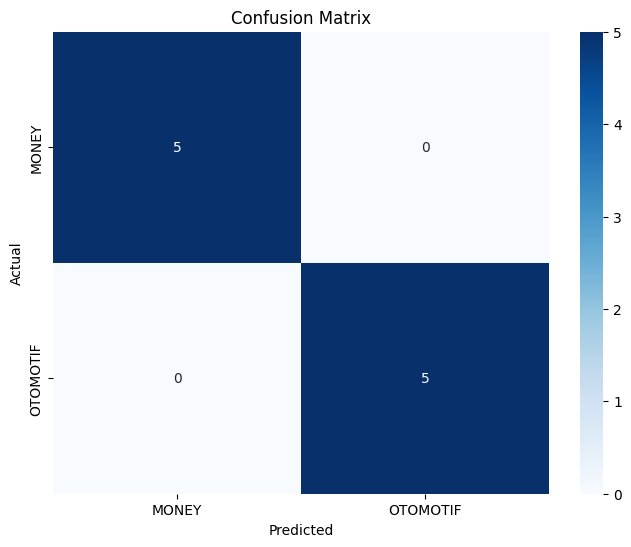

In [23]:
# Evaluation metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()